# Richardson-Lucy Deconvolution

---

> Author: <font color='#f78c40'>Samuel Farrens</font>    
> Year: 2018  
> Email: [samuel.farrens@cea.fr](mailto:samuel.farrens@cea.fr)  
> Website: <a href="https://sfarrens.github.io" target="_blank">https://sfarrens.github.io</a>

---

## Contents

1. [Set-Up](#Set-Up)
1. [Introduction](#Introduction)
1. [Example](#Example)

---

## Set-Up

Here we will import a couple of packages that will be needed throughout the notebook. 

Users new to Jupyter notebooks should note that cells are executed by pressing <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> (&#x21E7;+ &#x23ce;). See <a href="https://jupyter-notebook.readthedocs.io/en/stable/" target_="blanck">here</a> for more details.

In [1]:
# Tell Jupyter to display plots in this notebook.
%matplotlib inline

# Import the numpy package with the alias np.
import numpy as np           

# Import the pyplot package from matplotlib with the alias plt.
import matplotlib.pyplot as plt

# Import convolution routines from Astropy
from astropy.convolution import convolve_fft

# Import Richardson-Lucy method from SciKit-Image
from skimage.restoration import richardson_lucy

# Import NMSE metric from sf_tools
from sf_tools.image.quality import nmse

---

## Introduction

This notebook demonstrates the [Richardson-Lucy](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution)
method for deconvolution.

The method is named after William Richardson [(Richardson 1972)](http://adsabs.harvard.edu/abs/1972JOSA...62...55R) and Leon Lucy [(Lucy 1974)](http://adsabs.harvard.edu/abs/1974AJ.....79..745L) and takes the form

$$\hat{x}_{n+1}=\hat{x}_n \left(\frac{y}{H * \hat{x}_n} * H^*\right)$$

where $y$ is the obeserved image, $\hat{x}_n$ is the deconvolved image at iteration $n$, $H$ is the PSF and $H^*$ is the PSF rotated by 180 degrees.

We can implement this by first defining a convolution method,

In [2]:
# Convolution Method
def convolve(image, kernel):
            
    return convolve_fft(image, kernel, boundary='wrap', crop=False,
                        nan_treatment='fill', normalize_kernel=False)

then the deconvolution method.

In [3]:
def RL_Deconvolve(image, psf, n_iter=30):
    
    x_hat = 0.5 * np.ones(image.shape)
    psf_rot = np.rot90(psf, 2)
    
    for i in range(n_iter):
        
        x_hat *= convolve(image / convolve(x_hat, psf), psf_rot)
        
    return x_hat

---

## Example

Below we demonstrate the deconvolution method on astrophysical data. First we define a data set.

In [4]:
# Load an example galaxy image
x = np.load('/Users/farrens/Documents/Projects/PSF/data/clean_data/deep_galaxy_cube_10000_norm.npy')[8]

# Load an example PSF
H = np.load('/Users/farrens/Documents/Projects/PSF/data/psf/euclid_psf_wl0.6_norm.npy')[0]

# Set a noise levl
sigma = 0.00005

# Convolve the galaxy image with the PSF and add Gaussian random noise
y = convolve(x, H) + np.random.randn(*x.shape) * sigma

# Print the SNR of the image
snr = np.std(convolve(x, H)) / sigma
print('SNR = {}'.format(snr))

SNR = 47.561130306334576


Then we apply the Richardson-Lucy algorithm defined above along with that provided by [SciKit-Image](http://scikit-image.org/docs/dev/auto_examples/filters/plot_deconvolution.html?highlight=richardson) for comparison.

In [5]:
# Set number of iterations
n_iter = 20

# Apply Richardson-Lucy deconvolution
x_rl = RL_Deconvolve(y, H, n_iter=n_iter)

# Apply SciKit-Image implementation or Richardson-Lucy deconvolution
x_skrl = richardson_lucy(y, H, iterations=n_iter)

The results are displayed in the following figures.

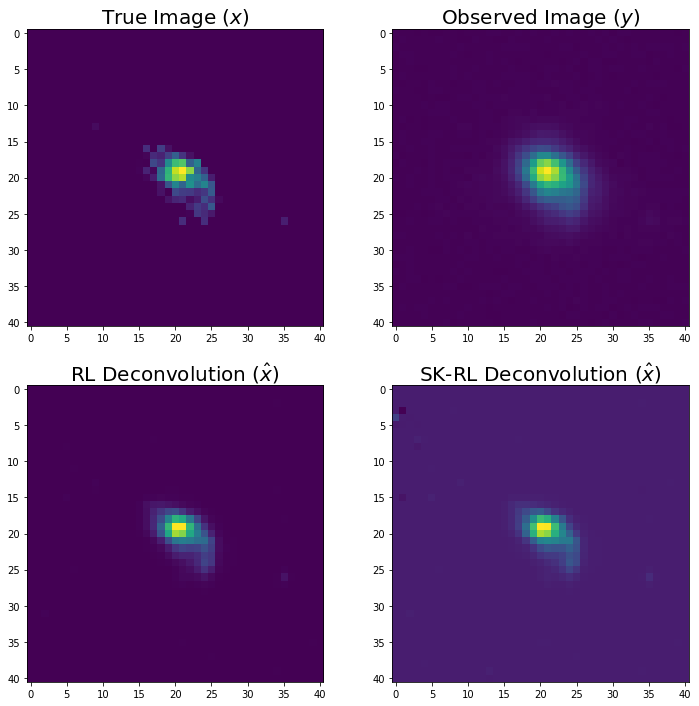

In [6]:
# Set the figure properties
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Plot the true image
ax[0, 0].imshow(x)
ax[0, 0].set_title('True Image ($x$)', fontsize=20)

# Plot the observed image
ax[0, 1].imshow(y)
ax[0, 1].set_title('Observed Image ($y$)', fontsize=20)

# Plot the Richardson-Lucy deconvolution
ax[1, 0].imshow(x_rl)
ax[1, 0].set_title('RL Deconvolution ($\hat{x}$)', fontsize=20)

# Plot the SciKit-Image deconvolution
ax[1, 1].imshow(x_skrl)
ax[1, 1].set_title('SK-RL Deconvolution ($\hat{x}$)', fontsize=20)

# Display the plots
plt.show()

The quality of the deconvolutions is measured using the Normalised Mean Square Error (NMSE).

In [7]:
# Print the NMSE between the true and RL deconvolved images
print('NMSE(x, x_rl) = {}'.format(nmse(x, x_rl)))

# Print the NMSE between the true and SK-RL deconvolved images
print('NMSE(x, x_skrl) = {}'.format(nmse(x, x_skrl)))

# Print the NMSE between the RL and SK-RL deconvolved images
print('NMSE(x_rl, x_skrl) = {}'.format(nmse(x_rl, x_skrl)))

NMSE(x, x_rl) = 0.041602257197892435
NMSE(x, x_skrl) = 0.04419398472263743
NMSE(x_rl, x_skrl) = 0.002960803593086073


*Note:* The RL method given in this notebooks produces identically results to the SciKit-Image implementation when using the [SciPy fftconvolve method](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.signal.fftconvolve.html).